In [176]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py

In [177]:
import fbprophet
from holidays import WEEKEND, HolidayBase
from dateutil.easter import easter
from dateutil.relativedelta import relativedelta as rd
from dateutil.easter import easter

In [178]:
df=pd.read_csv('D:/timedata/ex.csv')
df.head()

,Week,(US Dollar Million)
0,6-Apr-01,42689.0
1,13-Apr-01,42722.0
2,20-Apr-01,42765.0
3,27-Apr-01,42654.0
4,4-May-01,42782.0


In [179]:
df.dropna(inplace=True,axis=0)

In [180]:
df['Week']=pd.to_datetime(df['Week'])

In [181]:
df1 = df.copy(deep=True)
print(df1)

           Week  (US Dollar Million)
0    2001-04-06              42689.0
1    2001-04-13              42722.0
2    2001-04-20              42765.0
3    2001-04-27              42654.0
4    2001-05-04              42782.0
...         ...                  ...
1181 2023-06-02             595067.0
1182 2023-06-09             593749.0
1183 2023-06-16             596098.0
1184 2023-06-23             593198.0
1185 2023-06-30             595051.0

[1164 rows x 2 columns]


In [182]:
df.set_index('Week',inplace=True)

In [183]:
df.columns=['sales']

<Axes: xlabel='Week'>

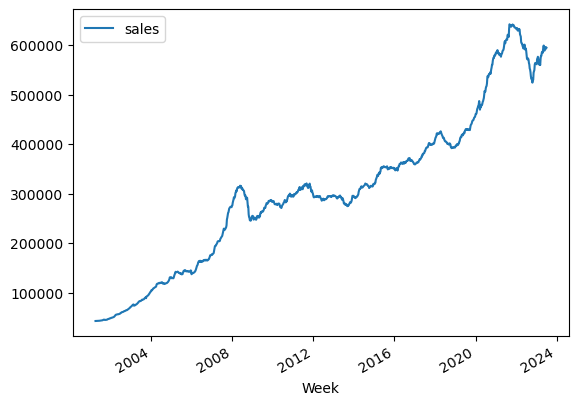

In [184]:
df.plot()

In [185]:
df['em']=df['sales'].ewm(alpha=0.2,adjust=False).mean()

<Axes: xlabel='Week'>

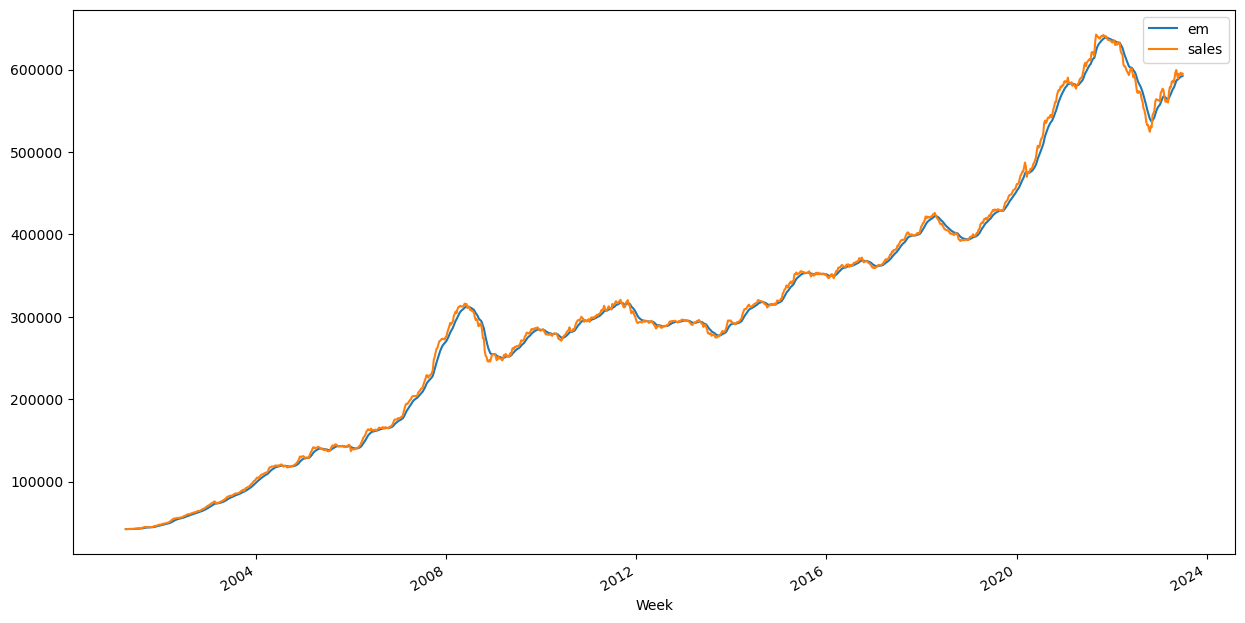

In [186]:
df[['em','sales']].plot(figsize=(15,8))

In [187]:
#here we can get idea that out next values is based on previous one ema

In [188]:
df['em5']=df['sales'].ewm(span=5).mean()

<Axes: xlabel='Week'>

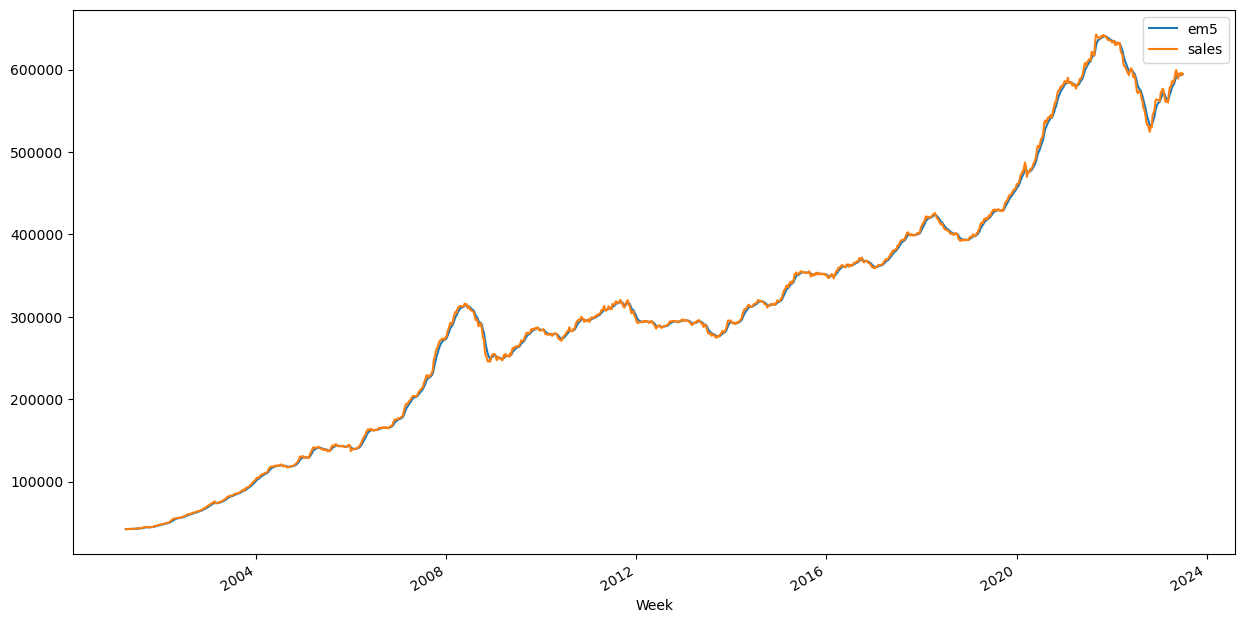

In [189]:
df[['em5','sales']].plot(figsize=(15,8))

In [190]:
#expo weighted moving avg

In [191]:
print(df.shape)
train=df.iloc[:-150]
test=df.iloc[-150:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1164, 3)
(1014, 3) (150, 3)
sales    537548.000000
em       525524.696393
em5      532519.635167
Name: 2020-08-21 00:00:00, dtype: float64 sales    595051.000000
em       592450.026246
em5      594171.044866
Name: 2023-06-30 00:00:00, dtype: float64


In [192]:
from statsmodels.tsa.ar_model import AutoReg

In [193]:
ARmodel = AutoReg(train['sales'], lags=1) #calling Auto regression model
ARmodel_fit = ARmodel.fit() #Fitting model

In [194]:
df.tail(5)

,sales,em,em5
Week,,,
2023-06-02,595067.0,589423.107046,592546.602132
2023-06-09,593749.0,590288.285637,592947.401421
2023-06-16,596098.0,591450.228510,593997.600948
2023-06-23,593198.0,591799.782808,593731.067298
2023-06-30,595051.0,592450.026246,594171.044866


In [195]:

start=len(train)
end=len(train)+len(test)-1


In [196]:
# making predictions
ypredicted = ARmodel_fit.predict(start=start,end=end).rename('Auto Reg')

ypredicted.index=df.index[start:end+1]
print(ypredicted)

Week
2020-08-21    535945.386279
2020-08-28    536639.298021
2020-09-04    537333.735624
2020-09-11    538028.699485
2020-09-18    538724.190005
                  ...      
2023-06-02    642256.339460
2023-06-09    643030.815847
2023-06-16    643805.879148
2023-06-23    644581.529808
2023-06-30    645357.768272
Name: Auto Reg, Length: 150, dtype: float64


<Axes: xlabel='Week'>

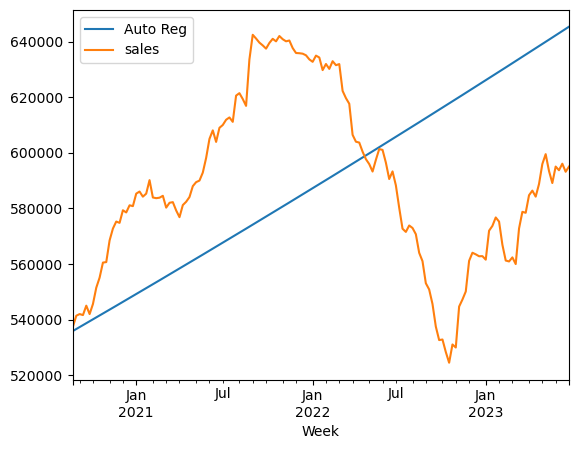

In [197]:
ypredicted.plot(legend=True)
test['sales'].plot(legend=True)

     

In [198]:

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['sales'],ypredicted)
print('MAE: %f' % mae)

MAE: 41332.607248


In [199]:

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['sales'],ypredicted,))
print(rmse)

46641.413900613734


In [200]:
from statsmodels.tsa.stattools import adfuller

In [201]:
def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    print('Results of Dickey-Fuller Test:')



    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [202]:
adfuller_test(df['sales'])

ADF Test Statistic : -0.5317515488872991
p-value : 0.8856700552580962
#Lags Used : 15
Number of Observations Used : 1148
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
Results of Dickey-Fuller Test:
Test Statistic                   -0.531752
p-value                           0.885670
#Lags Used                       15.000000
Number of Observations Used    1148.000000
Critical Value (1%)              -3.436059
Critical Value (5%)              -2.864061
Critical Value (10%)             -2.568112
dtype: float64


In [203]:
df['Difference']=df['sales']-df['sales'].shift(2)

In [204]:
adfuller_test(df['Difference'].dropna())

ADF Test Statistic : -5.52028469358776
p-value : 1.8843903719678726e-06
#Lags Used : 19
Number of Observations Used : 1142
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
Results of Dickey-Fuller Test:
Test Statistic                   -5.520285
p-value                           0.000002
#Lags Used                       19.000000
Number of Observations Used    1142.000000
Critical Value (1%)              -3.436089
Critical Value (5%)              -2.864074
Critical Value (10%)             -2.568119
dtype: float64


<Axes: xlabel='Week'>

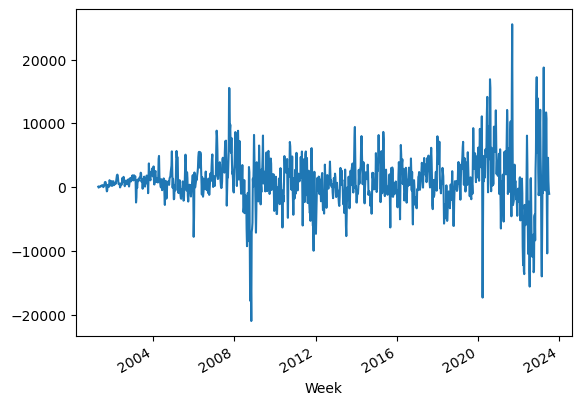

In [205]:
df['Difference'].plot()

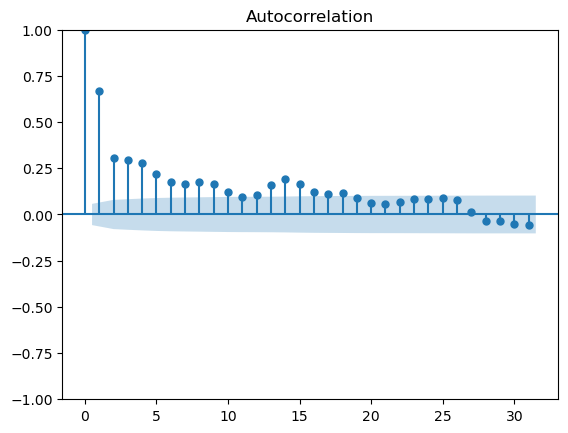

In [206]:
acf = plot_acf(df["Difference"].dropna())

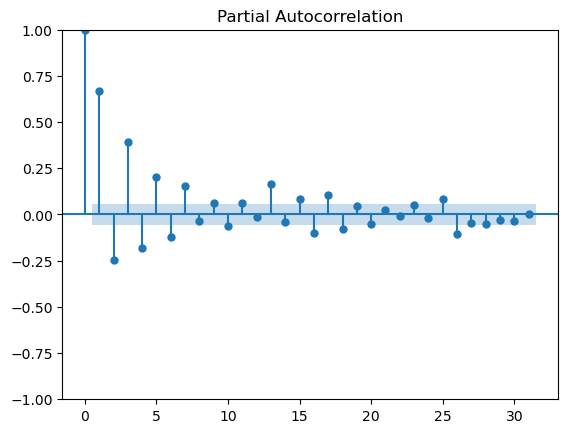

In [207]:
result = plot_pacf(df["Difference"].dropna())

In [208]:
print(df.shape)
train=df.iloc[:-150]
test=df.iloc[-150:]
print(train.shape,test.shape)

(1164, 4)
(1014, 4) (150, 4)


In [209]:


import statsmodels.api as sm

In [210]:
model = sm.tsa.arima.ARIMA(train['sales'], order=(7,2,3))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1014
Model:                 ARIMA(7, 2, 3)   Log Likelihood               -9128.688
Date:                Wed, 26 Jul 2023   AIC                          18279.376
Time:                        18:49:11   BIC                          18333.493
Sample:                             0   HQIC                         18299.933
                               - 1014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5602      0.055    -28.147      0.000      -1.669      -1.452
ar.L2         -0.3623      0.056     -6.511      0.000      -0.471      -0.253
ar.L3          0.4248      0.035     12.008      0.000       0.355       0.494
ar.L4          0.2954      0.034      8.624      0.000       0.228       0.363
ar.L5          0.2845      0.039      7.255      0.000       0.208       0.361
ar.L6          0.1570      0.045      3.488      0.000       0.069       0.245
ar.L7          0.0464      0.025      1.881      0.060      -0.002       0.095
ma.L1          0.8443      0.062     13.636      0.000       0.723       0.966
ma.L2         -0.9151      0.050    -18.245      0.000      -1.013      -0.817
ma.L3         -0.9292      0.053    -17.609      0.000      -1.033      -0.826
sigma2      3.964e+06   3.35e-08   1.18e+14      0.000    3.96e+06    3.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.57   Jarque-Bera (JB):              1696.30
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               2.61   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.83e+28. Standard errors may be unstable.
"""

<Axes: xlabel='Week'>

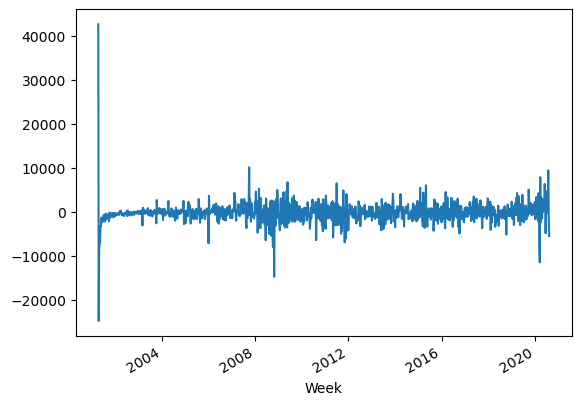

In [211]:
model.resid.plot()

In [212]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
pred.index=df.index[start:end+1]

In [213]:
print(pred)

Week
2020-08-21    536296.971025
2020-08-28    538470.275844
2020-09-04    539696.676562
2020-09-11    540642.198441
2020-09-18    541175.522052
                  ...      
2023-06-02    619240.288246
2023-06-09    619786.221595
2023-06-16    620329.844551
2023-06-23    620876.019028
2023-06-30    621419.611181
Name: predicted_mean, Length: 150, dtype: float64


<Axes: xlabel='Week'>

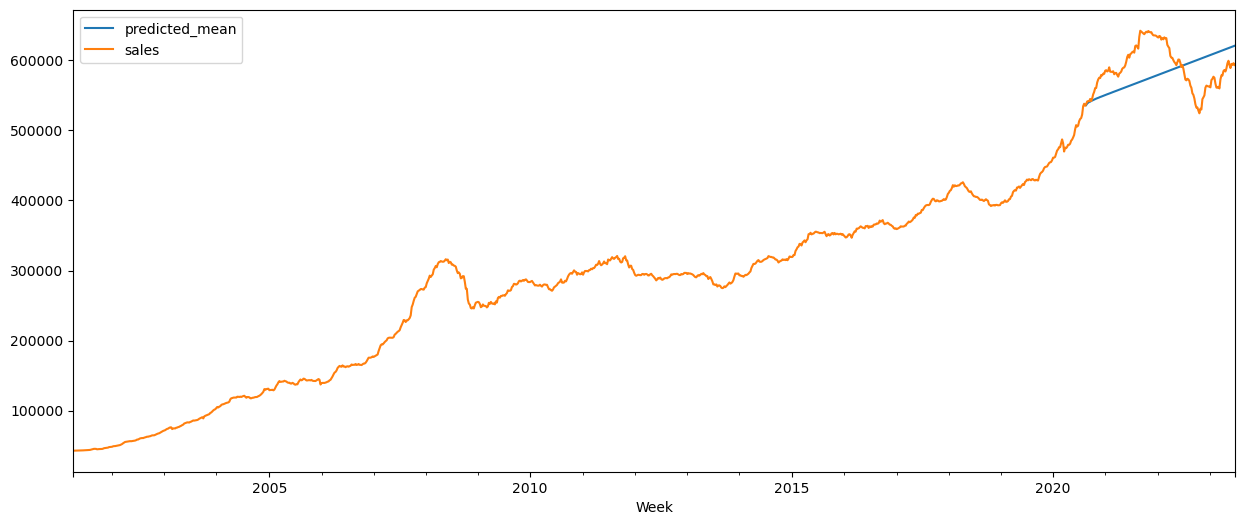

In [214]:
pred.plot(legend=True)
df['sales'].plot(legend=True,figsize=(15,6))

<Axes: xlabel='Week'>

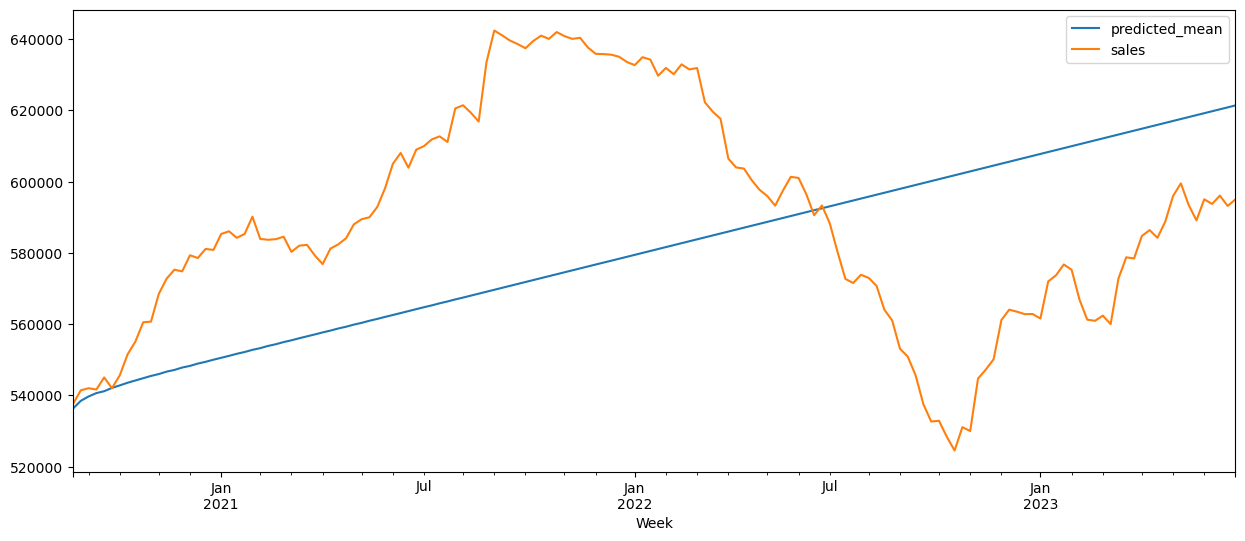

In [215]:
pred.plot(legend=True)
test['sales'].plot(legend=True,figsize=(15,6))

In [216]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test['sales'], pred)
mape = mean_absolute_percentage_error(test['sales'], pred)
rmse = np.sqrt(mean_squared_error(test['sales'], pred))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 36721.79799737815
mape - manual: 0.061996704911157136
rmse - manual: 41549.98112002138


In [217]:
test['sales'].mean()

589309.2733333333

In [218]:
df.tail()

,sales,em,em5,Difference
Week,,,,
2023-06-02,595067.0,589423.107046,592546.602132,1590.0
2023-06-09,593749.0,590288.285637,592947.401421,4611.0
2023-06-16,596098.0,591450.228510,593997.600948,1031.0
2023-06-23,593198.0,591799.782808,593731.067298,-551.0
2023-06-30,595051.0,592450.026246,594171.044866,-1047.0


In [219]:
model = sm.tsa.arima.ARIMA(df['sales'], order=(7,2,3))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1164
Model:                 ARIMA(7, 2, 3)   Log Likelihood              -10692.304
Date:                Wed, 26 Jul 2023   AIC                          21406.607
Time:                        18:49:23   BIC                          21462.244
Sample:                             0   HQIC                         21427.598
                               - 1164                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5904      0.023    -68.144      0.000      -1.636      -1.545
ar.L2         -0.4661      0.041    -11.406      0.000      -0.546      -0.386
ar.L3          0.4161      0.038     11.090      0.000       0.343       0.490
ar.L4          0.3262      0.036      9.162      0.000       0.256       0.396
ar.L5          0.3082      0.038      8.092      0.000       0.234       0.383
ar.L6          0.1416      0.042      3.361      0.001       0.059       0.224
ar.L7          0.0321      0.023      1.410      0.158      -0.013       0.077
ma.L1          0.8537      0.030     28.021      0.000       0.794       0.913
ma.L2         -0.8711      0.043    -20.256      0.000      -0.955      -0.787
ma.L3         -0.9826      0.023    -42.177      0.000      -1.028      -0.937
sigma2      5.874e+06   2.11e-08   2.79e+14      0.000    5.87e+06    5.87e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.25   Jarque-Bera (JB):              2347.93
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               3.73   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.34e+29. Standard errors may be unstable.
"""

<Axes: xlabel='Week'>

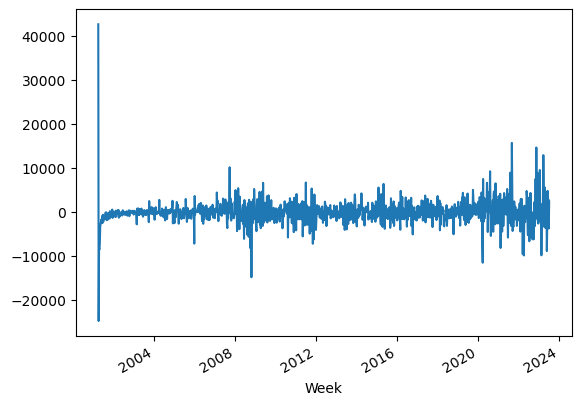

In [220]:
model.resid.plot()

In [221]:

index_future_dates=pd.date_range(start='2023-06-30',end='2024-06-30',freq='W')
#print(index_future_dates)
pred=model.predict(start=len(df),end=len(df)+52,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2023-07-02    596573.741567
2023-07-09    596387.765221
2023-07-16    597486.912138
2023-07-23    597420.926621
2023-07-30    598629.290670
2023-08-06    598734.137255
2023-08-13    599513.623863
2023-08-20    600028.229248
2023-08-27    600374.226982
2023-09-03    601301.561528
2023-09-10    601295.780445
2023-09-17    602439.014614
2023-09-24    602355.204286
2023-10-01    603420.826590
2023-10-08    603550.862776
2023-10-15    604286.647015
2023-10-22    604813.792101
2023-10-29    605130.667368
2023-11-05    606043.409265
2023-11-12    606052.352022
2023-11-19    607156.462062
2023-11-26    607110.923322
2023-12-03    608126.680970
2023-12-10    608298.486880
2023-12-17    608995.783374
2023-12-24    609545.964113
2023-12-31    609851.985058
2024-01-07    610757.659590
2024-01-14    610786.971478
2024-01-21    611857.432503
2024-01-28    611852.422048
2024-02-04    612824.260817
2024-02-11    613036.690745
2024-02-18    613700.666690
2024-02-25    614272.137640
2024-03-03    614570

<Axes: xlabel='Week'>

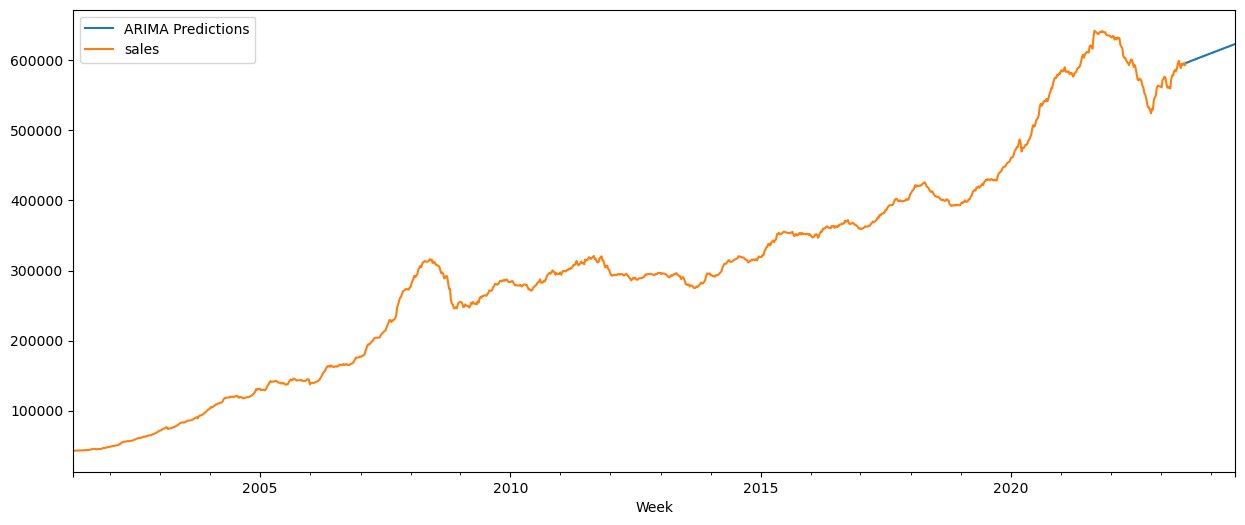

In [222]:
pred.plot(figsize=(12,5),legend=True)
df['sales'].plot(legend=True,figsize=(15,6))

<Axes: xlabel='Week'>

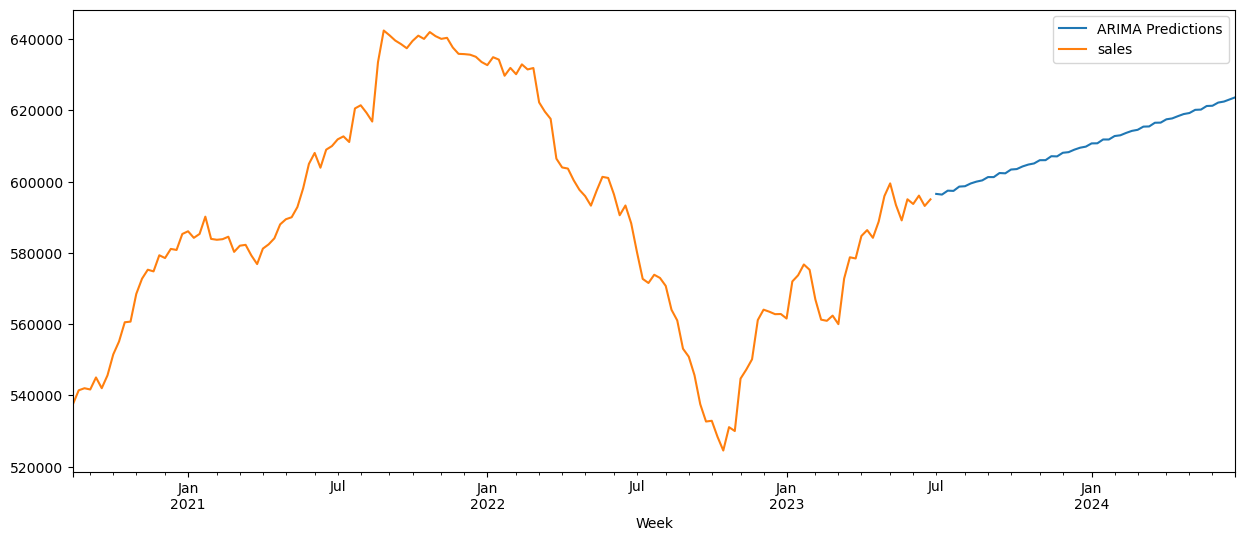

In [223]:
pred.plot(legend=True)
test['sales'].plot(legend=True,figsize=(15,6))

In [224]:
from fbprophet import Prophet

In [225]:
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'predict_seasonal_components',
 'predict_trend',
 'predict_uncertainty',
 'predictive_samples',
 'regressor_col

In [226]:
model=Prophet()

In [227]:
df1.head()

,Week,(US Dollar Million)
0,2001-04-06,42689.0
1,2001-04-13,42722.0
2,2001-04-20,42765.0
3,2001-04-27,42654.0
4,2001-05-04,42782.0


In [228]:
df1.columns=['ds','y']

In [229]:
model.fit(df1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [230]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [231]:
future_dates=model.make_future_dataframe(periods=52, freq='W', include_history=True)

In [232]:
future_dates.tail()

,ds
1211,2024-05-26
1212,2024-06-02
1213,2024-06-09
1214,2024-06-16
1215,2024-06-23


In [233]:
### Prediction
prediction=model.predict(future_dates)

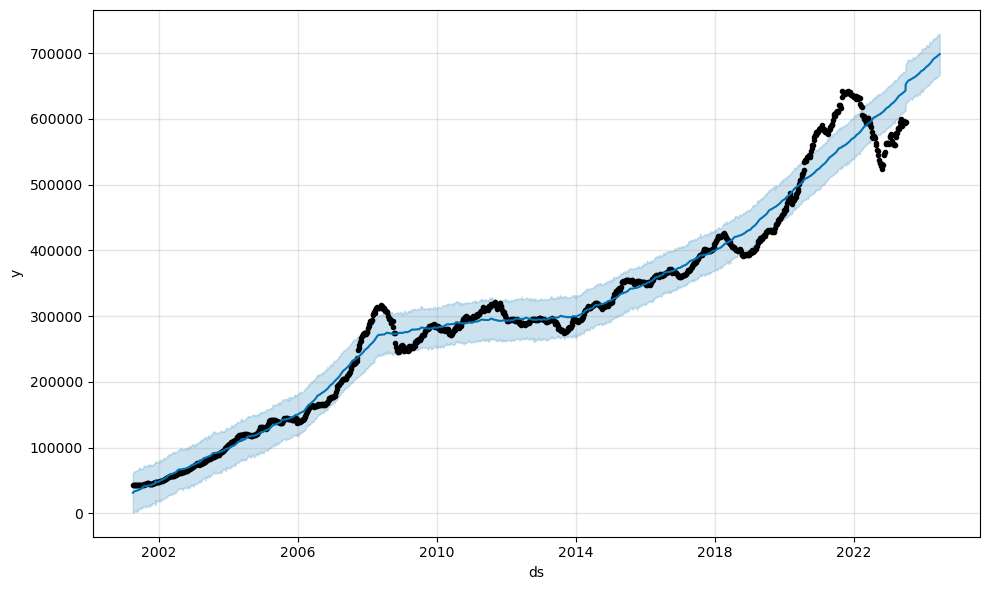

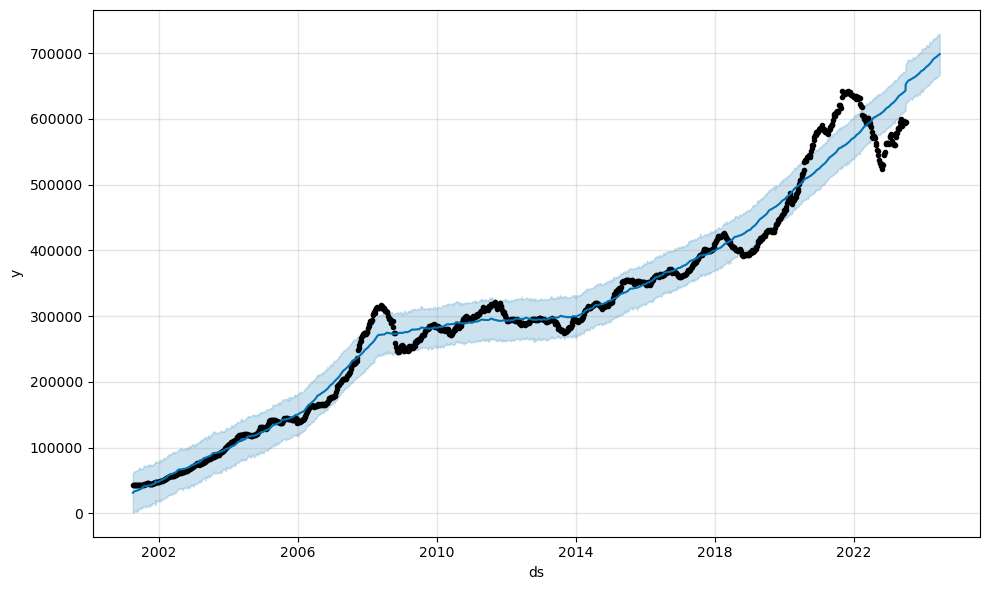

In [234]:
model.plot(prediction)

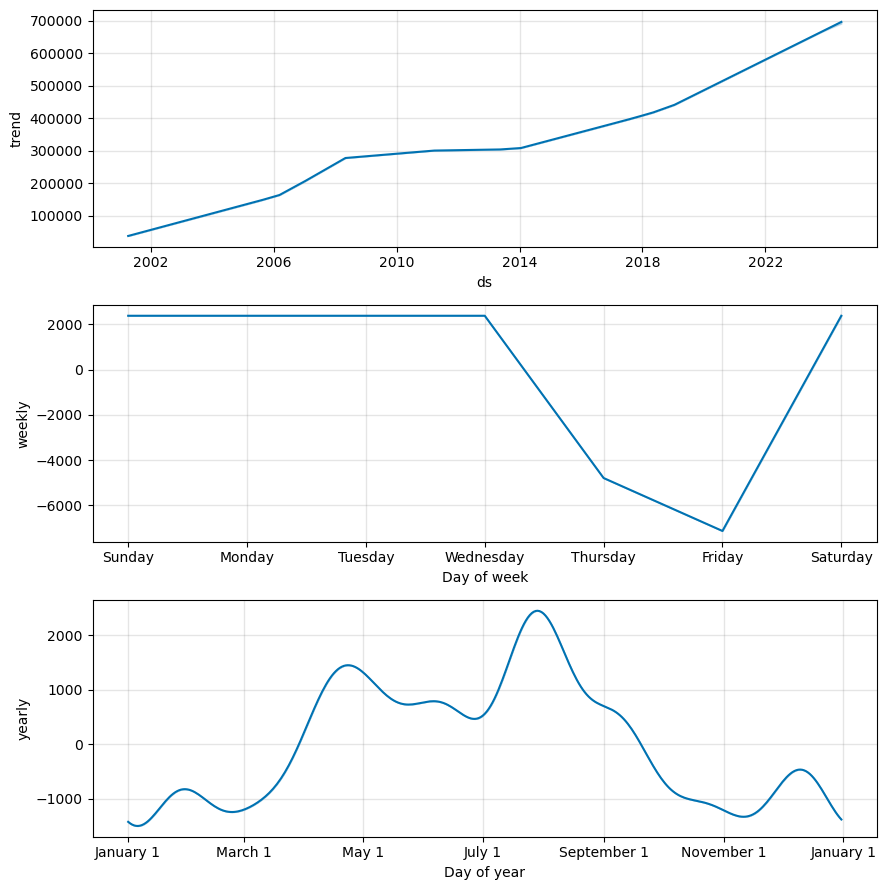

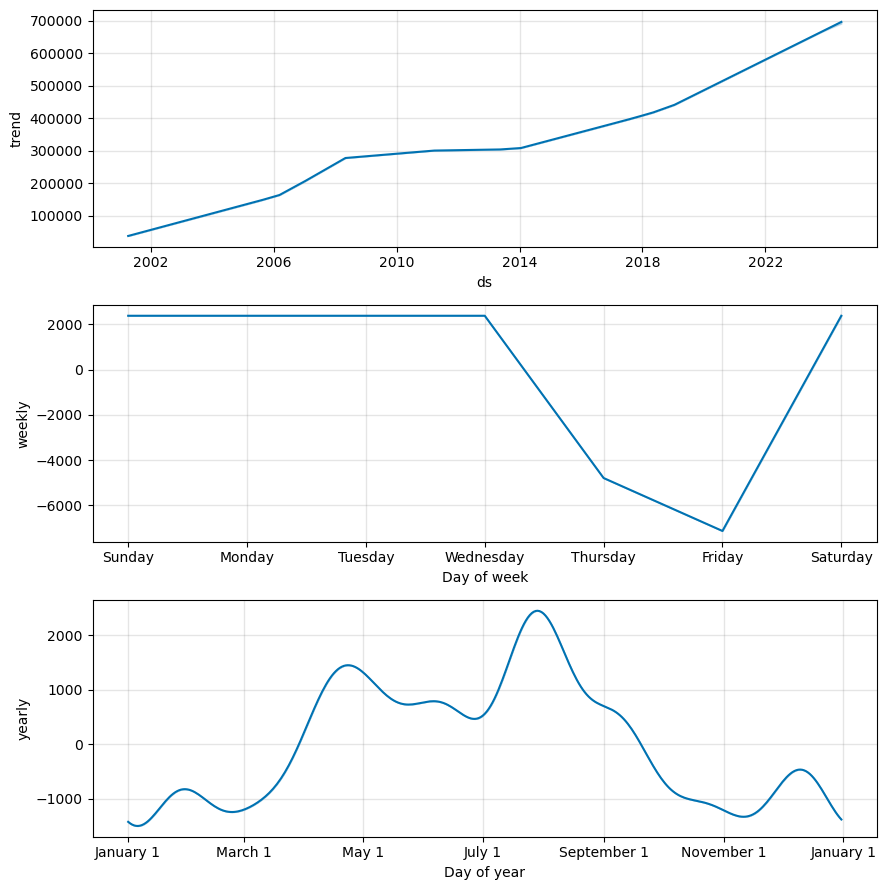

In [235]:
##### Visualize Each Components[Trends,yearly]
model.plot_components(prediction)

In [236]:
from fbprophet.diagnostics import cross_validation

In [237]:
df_cv=cross_validation(model,horizon="150 W",period='25 W',initial='52 W')

INFO:fbprophet:Making 39 forecasts with cutoffs between 2002-05-31 00:00:00 and 2020-08-14 00:00:00


  0%|          | 0/39 [00:00<?, ?it/s]

In [238]:
from fbprophet.diagnostics import performance_metrics
df_performance=performance_metrics(df_cv)
df_performance.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
137,1022 days,8.557304e+09,92505.695665,70650.836243,0.213072,0.190799,0.533333
138,1029 days,8.621506e+09,92852.066667,71026.112745,0.213826,0.191250,0.535043
139,1036 days,8.689081e+09,93215.238271,71423.767583,0.214634,0.192001,0.536752
140,1043 days,8.761604e+09,93603.440867,71887.318903,0.215616,0.192067,0.538462
141,1050 days,8.838121e+09,94011.279517,72349.161778,0.216596,0.192333,0.538462


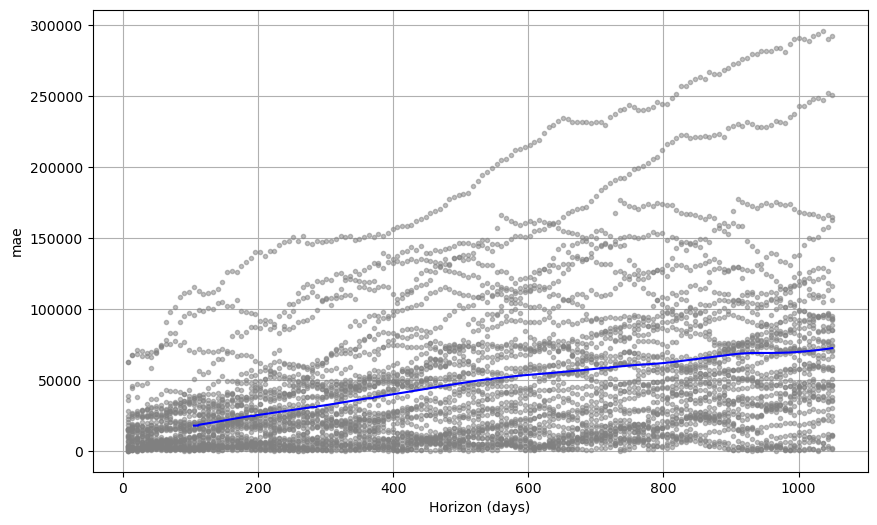

In [239]:
from fbprophet.plot import plot_cross_validation_metric
fig=plot_cross_validation_metric(df_cv,metric='mae')

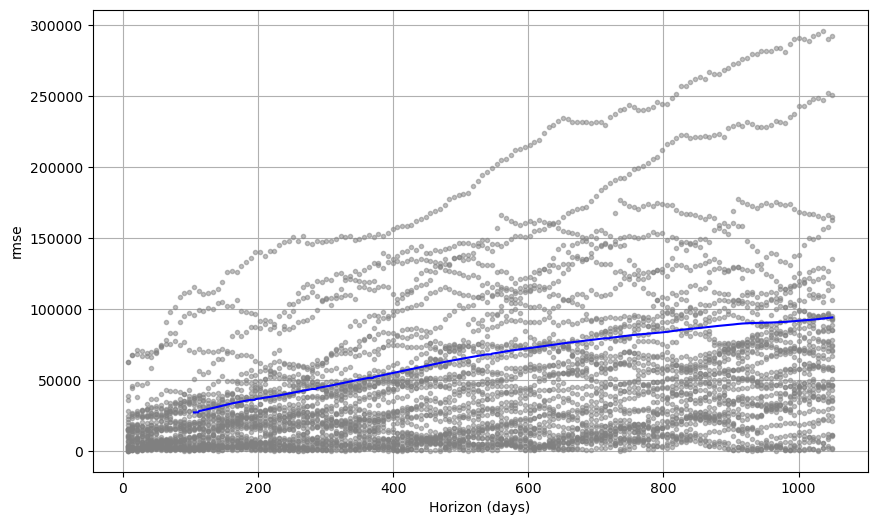

In [240]:
from fbprophet.plot import plot_cross_validation_metric
fig=plot_cross_validation_metric(df_cv,metric='rmse')

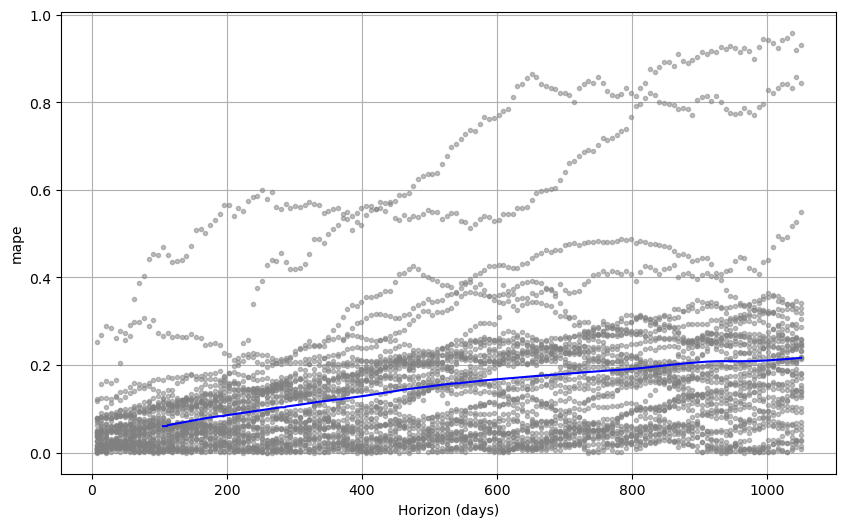

In [241]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [242]:
import chart_studio
chart_studio.plotly

<module 'chart_studio.plotly' from 'C:\\Users\\yahha\\.conda\\envs\\mlenv\\lib\\site-packages\\chart_studio\\plotly\\__init__.py'>

In [243]:
from fbprophet.plot import plot_plotly, plot_components_plotly

In [244]:
plot_plotly(model ,prediction)

In [245]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 40 forecasts with cutoffs between 2003-04-11 00:00:00 and 2022-06-30 00:00:00


  0%|          | 0/40 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2003-04-18,76580.616889,76227.387440,76926.195592,76748.0,2003-04-11
1,2003-04-25,76750.519629,76354.121050,77115.849088,77682.0,2003-04-11
2,2003-05-02,76960.481445,76582.600950,77343.761297,78278.0,2003-04-11
3,2003-05-09,77149.593212,76740.429488,77582.320048,79245.0,2003-04-11
4,2003-05-16,77265.594830,76823.028034,77702.514833,79911.0,2003-04-11


In [246]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,8.088572e+08,28440.415382,19708.772935,0.055490,0.044489,0.278846
1,38 days,8.044088e+08,28362.101986,19614.204913,0.055808,0.044016,0.283654
2,39 days,8.030762e+08,28338.598677,19747.266227,0.055984,0.044489,0.275000
3,40 days,8.013316e+08,28307.800617,19782.719673,0.056236,0.044240,0.276442
4,41 days,7.951460e+08,28198.333094,19667.691851,0.055888,0.044489,0.277885


In [247]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
324,361 days,3.374963e+09,58094.432582,43447.456296,0.128333,0.116433,0.287500
325,362 days,3.446088e+09,58703.391669,43846.608853,0.129194,0.117090,0.290865
326,363 days,3.539644e+09,59494.904907,44425.519143,0.131069,0.117090,0.292308
327,364 days,3.500071e+09,59161.396386,44314.207278,0.130945,0.119907,0.286859
328,365 days,3.558329e+09,59651.730936,44578.171257,0.131454,0.118404,0.285256


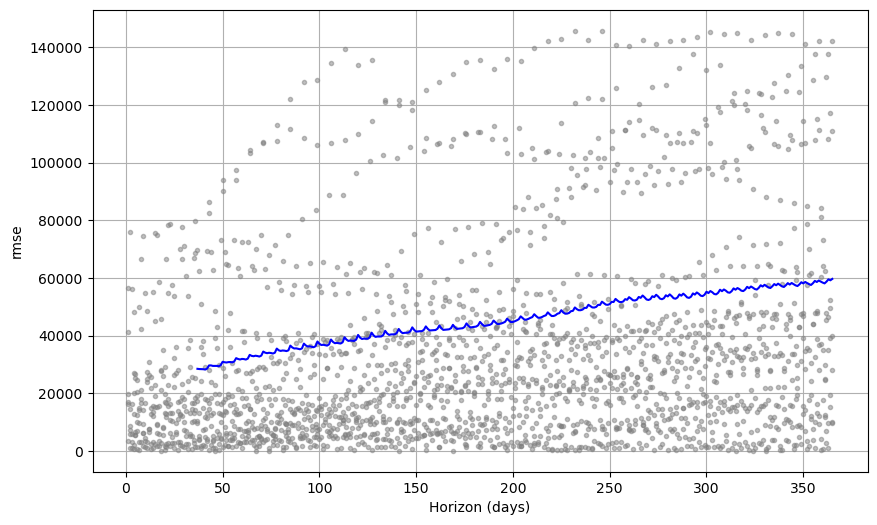

In [248]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

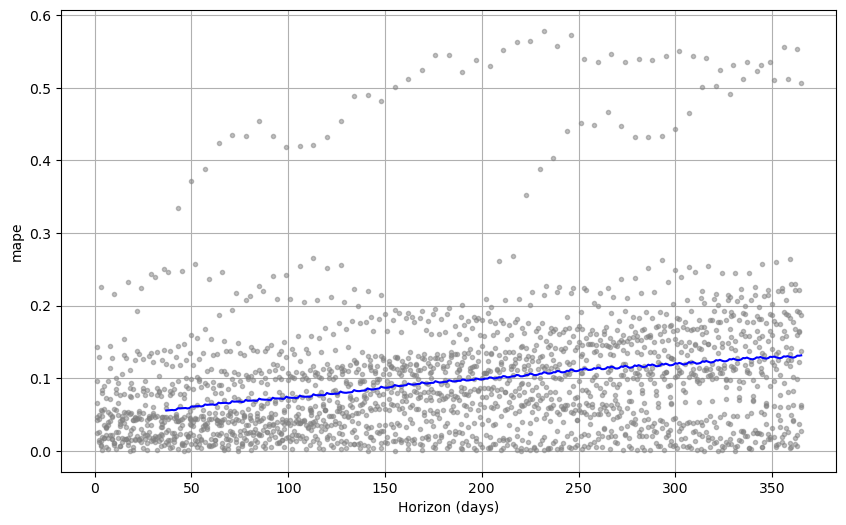

In [249]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

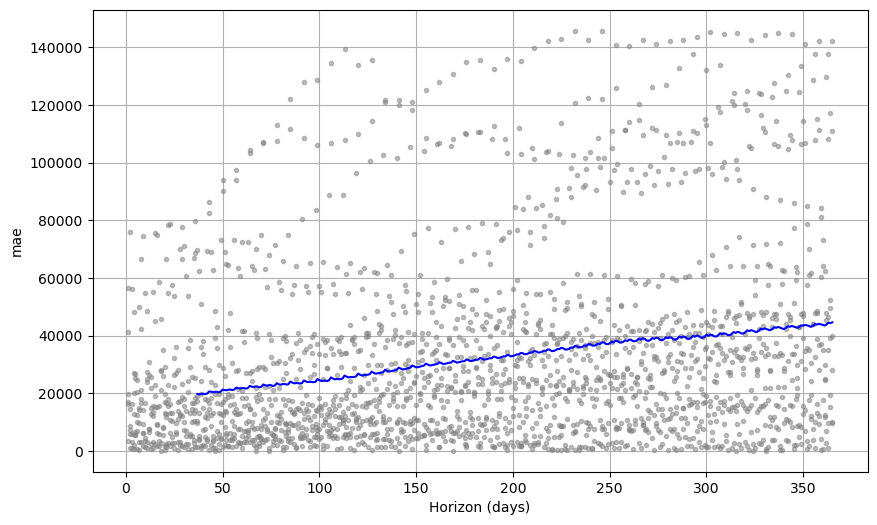

In [250]:
from fbprophet.plot import plot_cross_validation_metric
fig=plot_cross_validation_metric(df_cv,metric='mae')